In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision import datasets, transforms
import os

In [3]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    #tranforming training data
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    #transforming validation data
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Define the data directory
data_dir = 'dataset'
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 325, 'val': 63}


['mange', 'non_mange']

In [11]:
#Ex_model = models.resnet18(pretrained = True) #outdate and is might be removed in the future
#Load the Resnet18 model with pre-trained weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # Use the appropriate weights option

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.6325 Acc: 0.5046
val Loss: 0.9125 Acc: 0.6190
train Loss: 0.8464 Acc: 0.6215
val Loss: 0.4169 Acc: 0.8095
train Loss: 0.6764 Acc: 0.6738
val Loss: 0.6073 Acc: 0.6825
train Loss: 0.7757 Acc: 0.6462
val Loss: 0.2807 Acc: 0.9048
train Loss: 0.7030 Acc: 0.6708
val Loss: 0.7082 Acc: 0.6667
train Loss: 0.6724 Acc: 0.7262
val Loss: 0.3154 Acc: 0.8413
train Loss: 0.7598 Acc: 0.6338
val Loss: 0.7727 Acc: 0.6190
train Loss: 0.6228 Acc: 0.6892
val Loss: 0.4919 Acc: 0.7302
train Loss: 0.6179 Acc: 0.7292
val Loss: 0.4311 Acc: 0.8571
train Loss: 0.6870 Acc: 0.6769
val Loss: 0.3891 Acc: 0.7778
Training complete!


In [15]:
# Save the model
torch.save(model.state_dict(), 'wombat_mange_classification_model.pth')

<bold><font size = "5">Classification on Unseen Image </font></bold>  

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference.

In [22]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('wombat_mange_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

C:\Users\bowen_ksgfpxx\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bowen_ksgfpxx\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\bowen_ksgfpxx\AppData\Local\Temp\ipykernel_5320\4016318539.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

In [24]:
# Load and preprocess the unseen image
image_path = 'dataset/mange test.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [26]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['mange', 'non_mange']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: mange


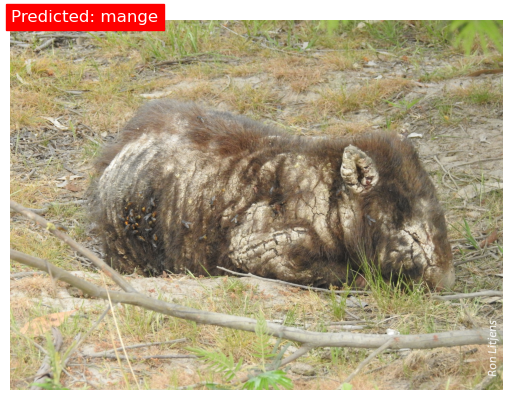

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()